In [4]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from getdist import plots


from reconstruction_comparison import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

### $\log Z$ and BIC for simulations/catalogues

In [ ]:
sims = ["Carrick2015", "Lilow2024", "CF4", "CF4gp", "csiborg2_main", "csiborg2X"]
catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]

for catalogue in catalogues:
    y_BIC = np.asarray([get_gof("BIC", sim, catalogue) for sim in sims])
    y_BIC -= y_BIC.min()
    y_lnZ = np.full_like(y_BIC, np.nan)
    # y_lnZ = np.asarray([get_gof("lnZ", sim, catalogue) for sim in sims])
    # y_lnZ -= y_lnZ.min()

    fig, ax_left = plt.subplots()
    fig.suptitle(f"{catalogue}")
    ax_right = ax_left.twinx()


    ax_left.plot(np.arange(len(sims)), y_lnZ, 'bo')
    ax_right.plot(np.arange(len(sims)), y_BIC, 'rx')

    # y-ticks
    ax_left.set_ylabel(r"$-\Delta \log \mathcal{Z}$", color="blue")
    ax_left.tick_params(axis='y', labelcolor="blue")
    ax_right.set_ylabel(r"$\Delta \mathrm{BIC}$", color="red")
    ax_right.tick_params(axis='y', labelcolor="red")

    ax_left.set_xticks(np.arange(len(sims)), simname_to_pretty(sims), rotation=35)
    fig.tight_layout()
    fig.savefig(f"../../plots/GOF_{catalogue}.png", dpi=450)
    fig.show()

### Setting $\beta = 1$?

In [ ]:
sims = ["Lilow2024", "CF4", "CF4gp", "csiborg1", "csiborg2_main", "csiborg2X"]
catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]

for catalogue in catalogues:
    y_lnZ = [get_gof("lnZ", sim, catalogue, sample_beta=True) - get_gof("lnZ", sim, catalogue, sample_beta=False) for sim in sims]
    y_BIC = [get_gof("BIC", sim, catalogue, sample_beta=True) - get_gof("BIC", sim, catalogue, sample_beta=False) for sim in sims]

    fig, ax_left = plt.subplots()
    fig.suptitle(rf"{catalogue} (higher signifies preference for $\beta = 1$)")
    ax_right = ax_left.twinx()

    ax_left.plot(np.arange(len(sims)), y_lnZ, 'bo')
    ax_right.plot(np.arange(len(sims)), y_BIC, 'rx')

    # y-ticks
    ax_left.set_ylabel(r"$\log \mathcal{Z}_{\beta} - \log \mathcal{Z}_{\beta = 1}$", color="blue")
    ax_left.tick_params(axis='y', labelcolor="blue")
    ax_right.set_ylabel(r"$\mathrm{BIC}_{\beta} - \mathrm{BIC}_{\beta = 1}$", color="red")
    ax_right.tick_params(axis='y', labelcolor="red")

    ax_left.set_xticks(np.arange(len(sims)), simname_to_pretty(sims), rotation=35)
    ax_left.axhline(0, color="black", linestyle="--", linewidth=1)
    fig.tight_layout()
    fig.savefig(f"../../plots/GOF_beta_{catalogue}.png", dpi=450)
    fig.show()


#### What $\beta$ is preferred by the data? 

In [ ]:
# sims = ["Lilow2024", "CF4", "CF4gp", "csiborg1", "csiborg2_main", "csiborg2X"]
sims = ["csiborg2_main", "csiborg2X"]
catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]
key = "beta"

for sim in sims:
    plt.figure()
    plt.title(simname_to_pretty(sim))

    for catalogue in catalogues:
        beta = get_samples(sim, catalogue)[key]
        plt.hist(beta, bins="auto", histtype="step", label=catalogue, density=1)


    plt.xlabel(names_to_latex([key], True)[0])
    plt.ylabel("Normalized PDF")
    # plt.xlim(0., 1.5)
    plt.legend()
    plt.savefig(f"../../plots/what_beta_{sim}.png", dpi=450)

    plt.tight_layout()
    plt.show()


### Flow | catalogue

In [ ]:
catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
params = ["Vmag", "beta", "sigma_v"]

for catalogue in catalogues:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim)
          for sim in sims]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{catalogue}', y=1.025)
     plt.gcf().tight_layout()
     plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')


### Flow | simulation

In [ ]:
catalogues = ["Pantheon+", "2MTF", "SFI_gals"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
params = ["Vmag", "l", "b", "beta", "sigma_v"]

for sim in sims:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim, catalogue)
          for catalogue in catalogues]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{sim}', y=1.025)
     plt.gcf().tight_layout()
     plt.gcf().savefig(f"../../plots/calibration_{sim}.png", dpi=500, bbox_inches='tight')
     plt.gcf().show()

### Stacking vs marginalising CB boxes

#### $V_{\rm ext}$

In [ ]:
sim = "csiborg2X"
catalogue = "2MTF"
key = "Vext"

X = [get_samples(sim, catalogue, nsim=nsim, convert_Vext_to_galactic=False)[key] for nsim in range(20)]
Xmarg = get_samples(sim, catalogue, convert_Vext_to_galactic=False)[key]


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"{simname_to_pretty(sim)}, {catalogue}")
fig.subplots_adjust(wspace=0.0, hspace=0)

for i in range(3):
    for n in range(20):
        axs[i].hist(X[n][:, i], bins="auto", alpha=0.25, histtype='step',
                    color='black', linewidth=0.5, density=1, zorder=0,
                    label="Individual box" if (n == 0 and i == 0) else None)

axs[i].hist(np.hstack([X[n][:, i] for n in range(20)]), bins="auto",
            histtype='step', color='blue', density=1,
            label="Stacked individual boxes" if i == 0 else None)
axs[i].hist(Xmarg[:, i], bins="auto", histtype='step', color='red',
            density=1, label="Marginalised boxes" if i == 0 else None)
    
axs[0].legend(fontsize="small", loc='upper left', frameon=False)

axs[0].set_xlabel(r"$V_{\mathrm{ext}, x} ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_xlabel(r"$V_{\mathrm{ext}, y} ~ [\mathrm{km} / \mathrm{s}]$")
axs[2].set_xlabel(r"$V_{\mathrm{ext}, z} ~ [\mathrm{km} / \mathrm{s}]$")
axs[0].set_ylabel("Normalized PDF")
fig.tight_layout()
fig.savefig(f"../../plots/consistency_{sim}_{catalogue}_{key}.png", dpi=450)
fig.show()


#### $\beta$ and others

In [ ]:
sim = "csiborg2_main"
catalogue = "Pantheon+"
key = "alpha"

X = [get_samples(sim, catalogue, nsim=nsim, convert_Vext_to_galactic=False)[key] for nsim in range(20)]
Xmarg = get_samples(sim, catalogue, convert_Vext_to_galactic=False)[key]


plt.figure()
plt.title(f"{simname_to_pretty(sim)}, {catalogue}")
for n in range(20):
    plt.hist(X[n], bins="auto", alpha=0.25, histtype='step',
             color='black', linewidth=0.5, density=1, zorder=0,
             label="Individual box" if n == 0 else None)

plt.hist(np.hstack([X[n] for n in range(20)]), bins="auto",
         histtype='step', color='blue', density=1,
         label="Stacked individual boxes")
plt.hist(Xmarg, bins="auto", histtype='step', color='red',
         density=1, label="Marginalised boxes")

plt.legend(fontsize="small", frameon=False, loc='upper left', ncols=3)
plt.xlabel(names_to_latex([key], True)[0])
plt.ylabel("Normalized PDF")

plt.tight_layout()
plt.savefig(f"../../plots/consistency_{sim}_{catalogue}_{key}.png", dpi=450)
plt.show()

### SN/TFR Calibration consistency

In [ ]:
# catalogues = ["LOSS", "Foundation", "Pantheon+", "2MTF", "SFI_gals"]
catalogues = ["Pantheon+"]
sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]

for catalogue in catalogues:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim)
          for sim in sims]

     if "Pantheon+" in catalogue or catalogue in ["Foundation", "LOSS"]:
          params = ["alpha_cal", "beta_cal", "mag_cal", "e_mu"]
     else:
          params = ["aTF", "bTF", "e_mu"]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{catalogue}', y=1.025)
     plt.gcf().tight_layout()
     # plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')

### $V_{\rm ext}$ comparison

In [ ]:
catalogues = ["LOSS"]
# sims = ["Carrick2015", "csiborg2_main", "csiborg2X"]
sims = ["Carrick2015"]
params = ["Vmag", "l", "b"]

for sim in sims:
     X = [samples_to_getdist(get_samples(sim, catalogue), sim, catalogue)
          for catalogue in catalogues]

     g = plots.get_subplot_plotter()
     g.settings.figure_legend_frame = False
     g.settings.alpha_filled_add = 0.75

     g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
     plt.gcf().suptitle(f'{simname_to_pretty(sim)}', y=1.025)
     plt.gcf().tight_layout()
    #  plt.gcf().savefig(f"../../plots/calibration_{sim}.png", dpi=500, bbox_inches='tight')
     plt.gcf().show()

###  Bulk flow in the simulation rest frame

In [ ]:
sims = ["Carrick2015", "csiborg1", "csiborg2_main", "csiborg2X"]
convert_to_galactic = False

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, sim in enumerate(sims):
    r, B = get_bulkflow_simulation(sim, convert_to_galactic=convert_to_galactic)
    if sim == "Carrick2015":
        if convert_to_galactic:
            B[..., 0] *= 0.43
        else:
            B *= 0.43

    for n in range(3):
        ylow, ymed, yhigh = np.percentile(B[..., n], [16, 50, 84], axis=0)
        axs[n].fill_between(r, ylow, yhigh, color=cols[i], alpha=0.5, label=simname_to_pretty(sim) if n == 0 else None)

axs[0].legend()
if convert_to_galactic:
    axs[0].set_ylabel(r"$B ~ [\mathrm{km} / \mathrm{s}]$")
    axs[1].set_ylabel(r"$\ell_B ~ [\degree]$")
    axs[2].set_ylabel(r"$b_B ~ [\degree]$")
else:
    axs[0].set_ylabel(r"$B_{x} ~ [\mathrm{km} / \mathrm{s}]$")
    axs[1].set_ylabel(r"$B_{y} ~ [\mathrm{km} / \mathrm{s}]$")
    axs[2].set_ylabel(r"$B_{z} ~ [\mathrm{km} / \mathrm{s}]$")

for n in range(3):
    axs[n].set_xlabel(r"$R ~ [\mathrm{Mpc}]$")


fig.tight_layout()
fig.savefig("../../plots/bulkflow_simulations_restframe.png", dpi=450)
fig.show()

### Bulk flow in the CMB rest frame

In [ ]:
sim = "csiborg2_main"
catalogues = ["Pantheon+", "2MTF", "SFI_gals"]


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
# fig.suptitle(f"Calibrated against {catalogue}")

for i, catalogue in enumerate(catalogues):
    r, B = get_bulkflow(sim, catalogue, sample_beta=True, convert_to_galactic=True,
                        weight_simulations=True, downsample=3)
    c = cols[i]
    for n in range(3):
        ylow, ymed, yhigh = np.percentile(B[..., n], [16, 50, 84], axis=-1)
        axs[n].plot(r, ymed, color=c)
        axs[n].fill_between(r, ylow, yhigh, alpha=0.5, color=c, label=catalogue)


# CMB-LG velocity
axs[0].fill_between([r.min(), 10.], [627 - 22, 627 - 22], [627 + 22, 627 + 22], color='black', alpha=0.5, zorder=0.5, label="CMB-LG", hatch="x")
axs[1].fill_between([r.min(), 10.], [276 - 3, 276 - 3], [276 + 3, 276 + 3], color='black', alpha=0.5, zorder=0.5, hatch="x")
axs[2].fill_between([r.min(), 10.], [30 - 3, 30 - 3], [30 + 3, 30 + 3], color='black', alpha=0.5, zorder=0.5, hatch="x")

# LCDM expectation
Rs,mean,std,mode,p05,p16,p84,p95 = np.load("/mnt/users/rstiskalek/csiborgtools/data/BulkFlowPlot.npy")
m = Rs < 175
axs[0].plot(Rs[m], mode[m], color="violet", zorder=0)
axs[0].fill_between(Rs[m], p16[m], p84[m], alpha=0.25, color="violet",
                    zorder=0, hatch='//', label=r"$\Lambda\mathrm{CDM}$")

for n in range(3):
    axs[n].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")

axs[0].legend()
axs[0].set_ylabel(r"$B ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_ylabel(r"$\ell_B ~ [\mathrm{deg}]$")
axs[2].set_ylabel(r"$b_B ~ [\mathrm{deg}]$")

axs[0].set_xlim(r.min(), r.max())

fig.tight_layout()
fig.savefig(f"../../plots/bulkflow_{sim}_{catalogue}.png", dpi=450)
fig.show()

### Smoothing scale dependence

In [10]:
simname = "Carrick2015"
catalogue = "Pantheon+"

#### Goodness-of-fit

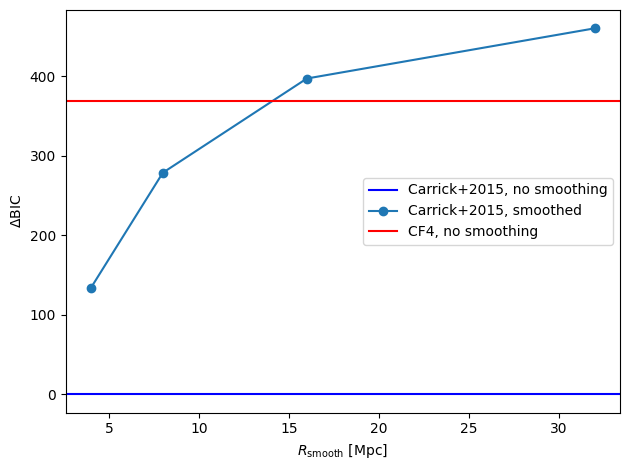

In [46]:
scales = [0, 4, 8, 16, 32]

y = np.asarray([get_gof("BIC", simname, catalogue, ksmooth=i)
                for i in range(len(scales))])
ymin = y.min()

y -= ymin
y_CF4 = get_gof("BIC", "CF4", catalogue) - ymin
y_CF4gp = get_gof("BIC", "CF4gp", catalogue) - ymin

plt.figure()
plt.axhline(y[0], color='blue', label="Carrick+2015, no smoothing")
plt.plot(scales[1:], y[1:], marker="o", label="Carrick+2015, smoothed")

plt.axhline(y_CF4, color='red', label="CF4, no smoothing")

plt.xlabel(r"$R_{\rm smooth} ~ [\mathrm{Mpc}]$")
plt.ylabel(r"$\Delta \mathrm{BIC}$")
plt.legend(ncols=1)

plt.tight_layout()
plt.savefig("../../plots/test_smooth.png", dpi=450)
plt.show()


Removed no burn in
Removed no burn in
Removed no burn in


/tmp/ipykernel_3872503/2011775450.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.gcf().tight_layout()


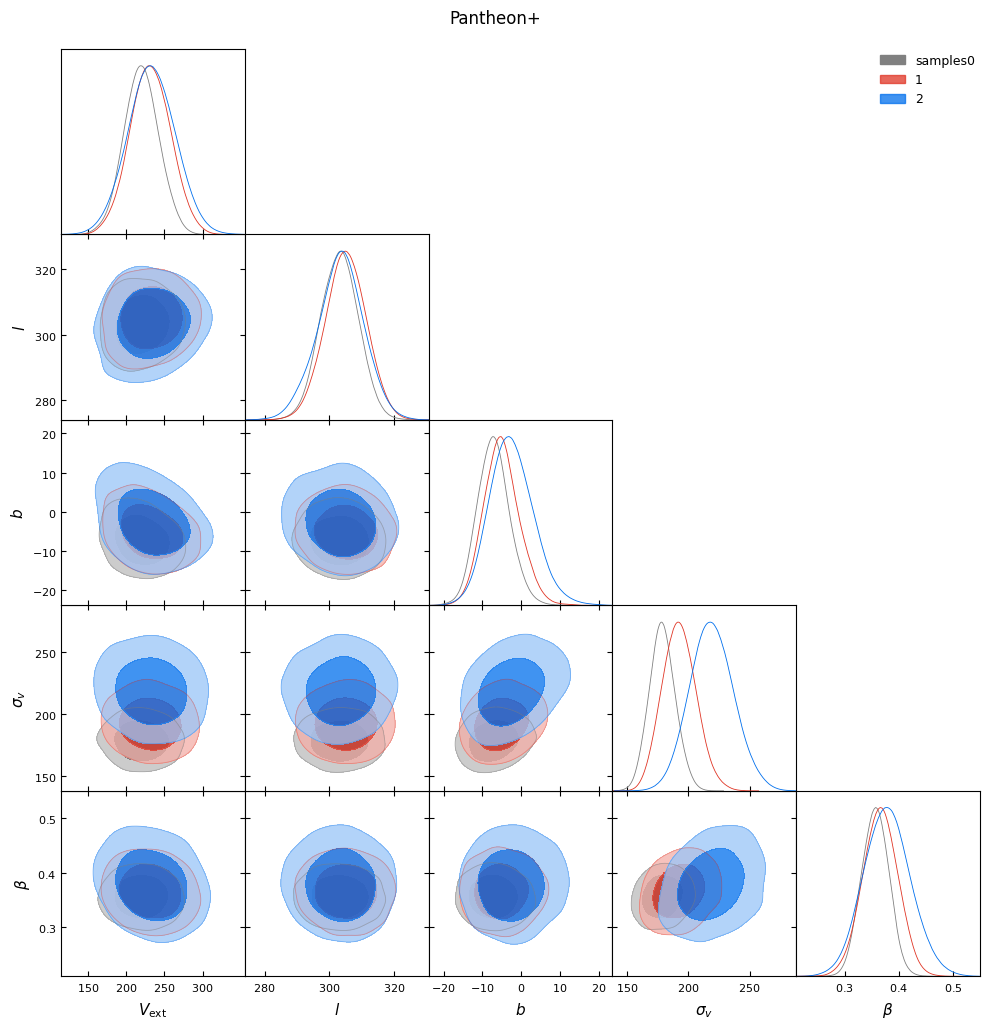

In [16]:
sim = "Carrick2015"
catalogue = "Pantheon+"


X = [samples_to_getdist(get_samples(sim, catalogue, ksmooth=ksmooth), ksmooth)
     for ksmooth in [0, 1, 2]]

params = ["Vmag", "l", "b", "sigma_v", "beta"]
# if "Pantheon+" in catalogue or catalogue in ["Foundation", "LOSS"]:
#      params += ["alpha_cal", "beta_cal", "mag_cal", "e_mu"]
# else:
#      params += ["aTF", "bTF", "e_mu"]



g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75

g.triangle_plot(X, params=params, filled=True, legend_loc='upper right')
plt.gcf().suptitle(f'{catalogue}', y=1.025)
plt.gcf().tight_layout()
plt.gcf().savefig(f"../../plots/calibration_{catalogue}.png", dpi=500, bbox_inches='tight')